<a href="https://colab.research.google.com/github/1eetnals/Body-Morphometry-kidney-and-tumor/blob/main/test_label_to_nifti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    MapTransform,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.7.dev2131
Numpy version: 1.20.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 57467c75bff90e6c9da74461f7da3a828a39626b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.2.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
test_path = '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/'
Input_folder = os.listdir(test_path)
test_files = []

for i in range(0,len(Input_folder)):
    if Input_folder[i].startswith('nifti'):
        data_file=os.listdir(test_path+Input_folder[i])
        for j in range(0,len(data_file)):
            if data_file[j].endswith('.nii.gz'):
                test_files.append(test_path+Input_folder[i]+'/'+data_file[j])

test_files.sort()
test_files

['/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test001/ct_test001.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test002/ct_test002.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test003/ct_test003.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test004/ct_test004.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test005/ct_test005.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test006/ct_test006.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test007/ct_test007.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test008/ct_test008.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test009/ct_test009.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test010/ct_test010.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test011/ct_test011.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test012/ct_test012.nii.gz',
 '/home/hufsbme/

In [ ]:
test_ind=np.arange(0,len(test_files))
data_dicts=[
    {
        "image": test_files[idx],
    }
    for idx in test_ind
]

test_f=data_dicts
len(test_f)
test_f

[{'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test001/ct_test001.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test002/ct_test002.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test003/ct_test003.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test004/ct_test004.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test005/ct_test005.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test006/ct_test006.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test007/ct_test007.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test008/ct_test008.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test009/ct_test009.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test010/ct_test010.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_test/NIFTI/nifti_test01

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        #ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-285, a_max=350, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        ToTensord(keys=["image"]),
    ]
)

In [ ]:
test_ds = CacheDataset(
    data=test_f, transform=test_transforms, cache_rate=1.0, num_workers=0
)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

Loading dataset: 100%|██████████| 83/83 [01:41<00:00,  1.23s/it]


image shape: torch.Size([1, 1, 342, 281, 32])


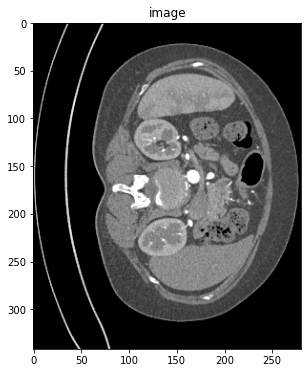

image shape: torch.Size([1, 1, 342, 261, 32])


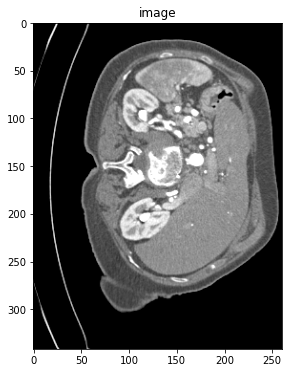

image shape: torch.Size([1, 1, 339, 255, 32])


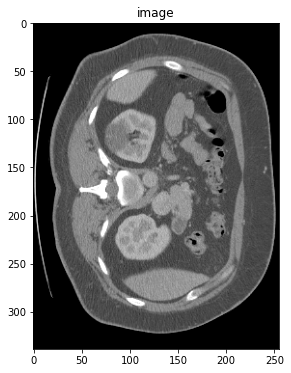

In [ ]:
i = 0
for test_image in test_loader:
#img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = test_image["image"]
    img_shape = img.shape
    print(f"image shape: {img_shape}")

    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(img[0,0, :, :, 10].detach().cpu(), cmap="gray")
    plt.show()
    i+=1
    if i==3:
        break

In [ ]:
device = torch.device("cuda:1")
!nvidia-smi

Fri Aug 27 18:29:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 27%   30C    P8    18W / 250W |   1047MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:AF:00.0 Off |                  N/A |
| 27%   

In [ ]:
model = UNETR(
    in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=64, #16
    hidden_size=384, #768
    mlp_dim=1536, #3072
    num_heads=12,
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [ ]:
out_dir='/Users/hufsbme/gyu/tmp'
import nibabel as nib

In [ ]:
root_dir='/home/hufsbme/gyu/.vscode/moai2021_train'

In [ ]:
import torch.nn as N
upsample=N.Upsample(size=(512,512,64), scale_factor=None, mode='nearest', align_corners=None)

In [ ]:
case_num = 1
i=0
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for test_image in test_loader:
    #img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
        img = test_image["image"]
        #test_inputs = torch.unsqueeze(img, 1).to(device)
        test_inputs=img.to(device)
        
        test_outputs = sliding_window_inference(
            test_inputs, (96, 96, 32), 2, model, overlap=0.8
        )
        test_inputs=upsample(test_inputs)
        test_outputs=upsample(test_outputs)
        print(test_inputs.shape)
        ##print(val_outputs)
        test_outputs_new=np.array(torch.argmax(test_outputs, dim=1).detach().cpu().numpy()[0],dtype=np.float64)
        ##print('#####')
        ##print(val_outputs_new)
        #h1=nib.Nifti1Image(test_inputs.cpu().numpy()[0,0],test_image['image_meta_dict']['affine'][0])
        #nib.save(h1,os.path.join(out_dir,f'test_image_{case_num}.nii.gz'))
        h2=nib.Nifti1Image(test_outputs_new,test_image['image_meta_dict']['affine'][0])
        nib.save(h2,os.path.join(out_dir,f'test_label_{case_num}.nii.gz'))
        case_num+=1
        
        '''plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.title("image")
        plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 10], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.title("output")
        plt.imshow(
            torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :,10]
        )
        plt.show()'''
       